In [31]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

In [32]:
epochs = 100
lr = 1e-3
batch_size = 64

In [33]:
# 设置GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [34]:
trans_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

In [35]:
trans_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4942, 0.4851, 0.4504], std=[0.2467, 0.2429, 0.2616]),
])

In [36]:
train_data = datasets.CIFAR10('data', train=True, download=True, transform=trans_train)

test_data = datasets.CIFAR10('data', train=False, download=True, transform=trans_test)

Files already downloaded and verified
Files already downloaded and verified


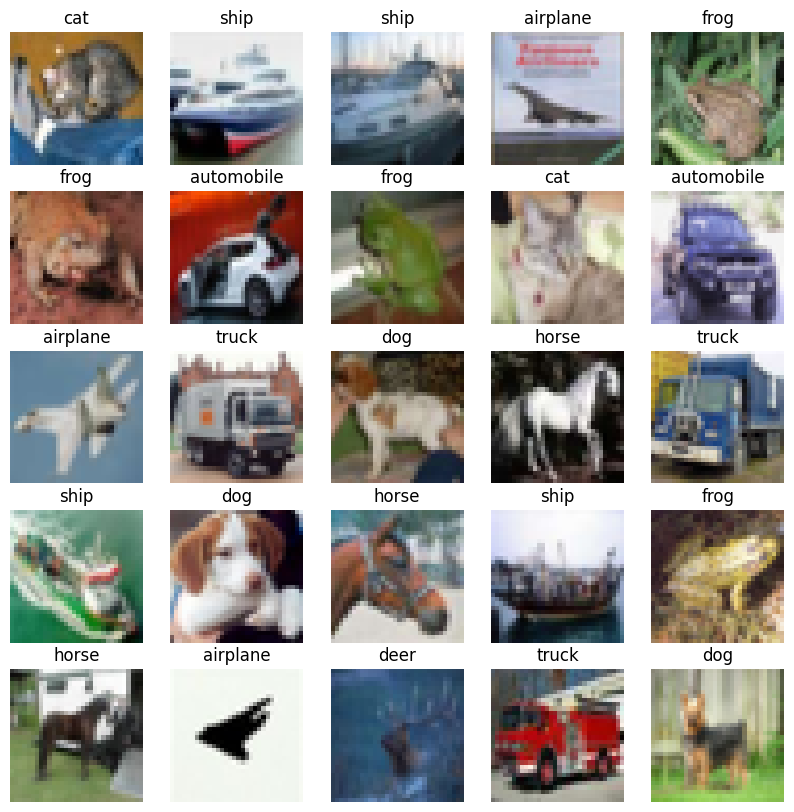

In [37]:
# CIFAR-10 classes
from matplotlib import pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Get the first 25 images and labels from the test dataset
images = test_data.data[:25]
labels = test_data.targets[:25]

# Create a figure with 5 rows and 5 columns
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images and labels, and plot them on the subplots
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')
    ax.set_title(f'{class_names[labels[i]]}')

# Show the figure
plt.show()

In [38]:
valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))

# 进行随机洗牌
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# 使用 SequentialSampler 以保持数据顺序
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# DataLoader 使用定义的 sampler，保持数据加载的顺序性
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [39]:
# def mean_std(loader):
#     data = next(iter(loader))[0]
#     mean = torch.mean(data, dim=[0, 2, 3])
#     std = torch.std(data, dim=[0, 2, 3])
#     return mean, std

# train_mean, train_std = mean_std(train_loader)
# test_mean, test_std = mean_std(test_loader)
# print("train_mean：{}".format(train_mean))
# print("train_std：{}".format(train_std))
# print("test_mean：{}".format(test_mean))
# print("test_std：{}".format(test_std))

In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 第一层卷积层，输入通道为3（RGB图像），输出通道为32
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # 第二层卷积层，输入通道为32，输出通道为64
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # 第三层卷积层，输入通道为64，输出通道为128
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # 池化层
        self.pool = nn.MaxPool2d(2, 2)
        # 全连接层
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)  # CIFAR-10有10个类别

    def forward(self, x):
        # 第一层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        # 第二层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        # 第三层卷积+激活+池化
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))
        # 展平
        x = x.view(-1, 128 * 4 * 4)
        # 全连接层+激活
        x = nn.functional.relu(self.fc1(x))
        # 输出层
        x = self.fc2(x)
        return x

In [41]:
# 实例化模型
model = Net().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [42]:
# 训练模型
def train_model(model, train_loader, valid_loader, epochs, device, criterion, patience=3):
    train_losses = []
    best_loss = float('inf')
    counter = 0 

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')
        train_losses.append(epoch_loss)

        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total
        print(f'Validation Accuracy: {validation_accuracy}%')

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping triggered.')
                break

    return train_losses



# def train_model(model, train_loader, valid_loader, epochs, device):
#     for epoch in range(epochs):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             # 梯度清零
#             optimizer.zero_grad()

#             # 前向传播
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # 反向传播和优化
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item()

#         print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

#         # 在验证集上评估模型性能
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for images, labels in valid_loader:
#                 images, labels = images.to(device), labels.to(device)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         print(f'Validation Accuracy: {100 * correct / total}%')

In [43]:
# 测试模型
def test_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test Accuracy: {100 * correct / total}%')
    return correct / total

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Get the predicted labels for the test dataset

import seaborn as sns

def test_draw_model(model, test_loader, device):
    model.eval()  # 设置模型为评估模式
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())

    # Convert the predicted labels and true labels to numpy arrays
    y_pred = np.array(y_pred)
    y_true = np.array(test_data.targets[:len(y_pred)])

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy and recall
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print(f'Accuracy: {accuracy}')
    print(f'Recall: {recall}')
    return accuracy, recall

Learning rate: 0.1
Epoch 1, Loss: 1.9772767107009888
Validation Accuracy: 36.35%
Epoch 2, Loss: 1.6230718734741212
Validation Accuracy: 43.57%
Epoch 3, Loss: 1.467042748451233
Validation Accuracy: 46.89%
Epoch 4, Loss: 1.3874319463729858
Validation Accuracy: 50.31%
Epoch 5, Loss: 1.3086716959953308
Validation Accuracy: 53.75%
Epoch 6, Loss: 1.2543831857681274
Validation Accuracy: 57.04%
Epoch 7, Loss: 1.2024574630737304
Validation Accuracy: 56.38%
Epoch 8, Loss: 1.1814980049133301
Validation Accuracy: 59.25%
Epoch 9, Loss: 1.1485247142791748
Validation Accuracy: 59.23%
Epoch 10, Loss: 1.1245926148414611
Validation Accuracy: 56.44%
Epoch 11, Loss: 1.1026305367469789
Validation Accuracy: 60.56%
Epoch 12, Loss: 1.0852673509597779
Validation Accuracy: 62.67%
Epoch 13, Loss: 1.067473986530304
Validation Accuracy: 61.05%
Epoch 14, Loss: 1.04668978433609
Validation Accuracy: 61.35%
Epoch 15, Loss: 1.0312335530281067
Validation Accuracy: 62.52%
Epoch 16, Loss: 1.0097139854431152
Validation Acc

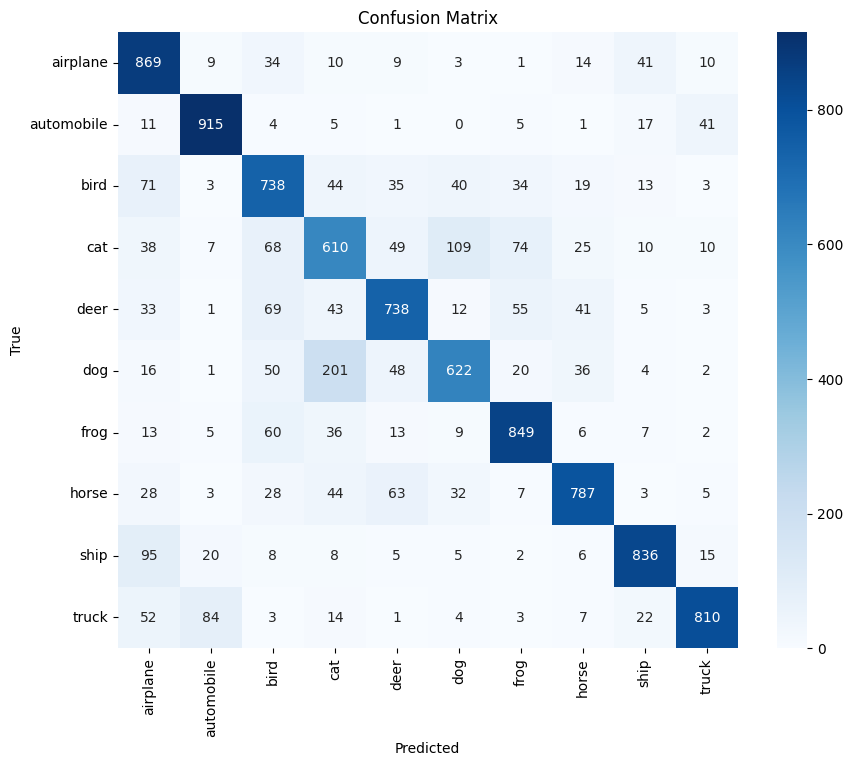

Accuracy: 0.7774
Recall: 0.7774000000000001
Learning rate: 0.01
Epoch 1, Loss: 1.6485763242721558
Validation Accuracy: 47.29%
Epoch 2, Loss: 1.3890097799301147
Validation Accuracy: 51.52%
Epoch 3, Loss: 1.2463702663421632
Validation Accuracy: 53.05%
Epoch 4, Loss: 1.1575478204727172
Validation Accuracy: 59.19%
Epoch 5, Loss: 1.0867277634620667
Validation Accuracy: 61.16%
Epoch 6, Loss: 1.0246904698371888
Validation Accuracy: 63.43%
Epoch 7, Loss: 0.9813598526954651
Validation Accuracy: 64.79%
Epoch 8, Loss: 0.9352145209312439
Validation Accuracy: 66.43%
Epoch 9, Loss: 0.8917079054832459
Validation Accuracy: 66.98%
Epoch 10, Loss: 0.8624793846130371
Validation Accuracy: 67.4%
Epoch 11, Loss: 0.8392813875675201
Validation Accuracy: 69.7%
Epoch 12, Loss: 0.8142575545310974
Validation Accuracy: 70.47%
Epoch 13, Loss: 0.789736137342453
Validation Accuracy: 70.02%
Epoch 14, Loss: 0.7703792159080506
Validation Accuracy: 69.68%
Epoch 15, Loss: 0.7500105541706085
Validation Accuracy: 70.93%
Epo

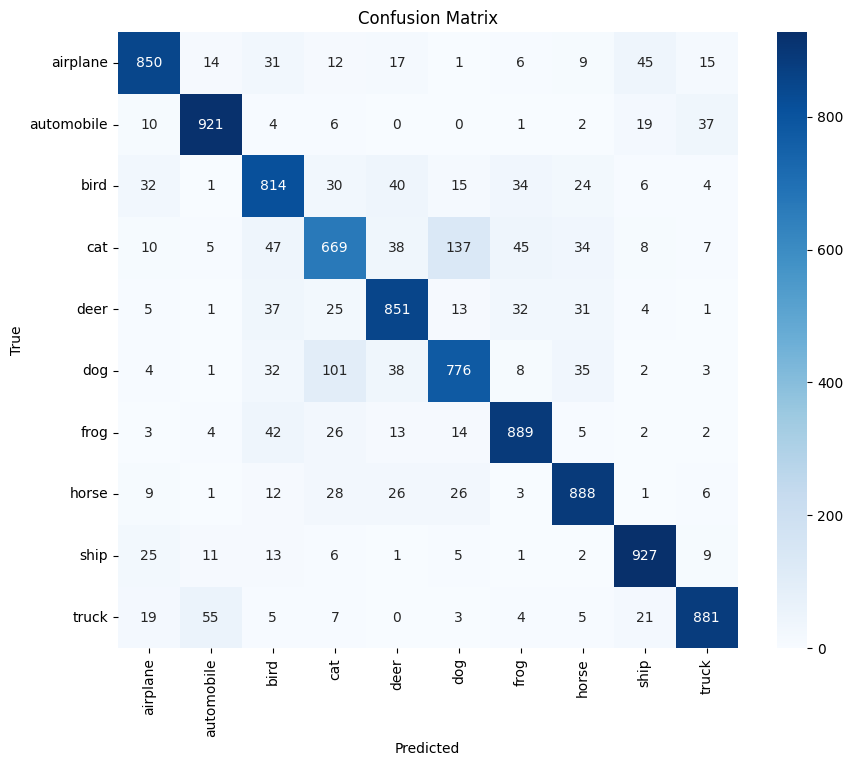

Accuracy: 0.8466
Recall: 0.8465999999999999
Learning rate: 0.001
Epoch 1, Loss: 1.7592102993011474
Validation Accuracy: 42.33%
Epoch 2, Loss: 1.4859381772994995
Validation Accuracy: 48.88%
Epoch 3, Loss: 1.3615360110282897
Validation Accuracy: 52.5%
Epoch 4, Loss: 1.2837815822601317
Validation Accuracy: 54.34%
Epoch 5, Loss: 1.2210684066772461
Validation Accuracy: 56.38%
Epoch 6, Loss: 1.1749610303878784
Validation Accuracy: 57.89%
Epoch 7, Loss: 1.1338593001365662
Validation Accuracy: 60.36%
Epoch 8, Loss: 1.1018263220787048
Validation Accuracy: 62.27%
Epoch 9, Loss: 1.0691731609344481
Validation Accuracy: 62.31%
Epoch 10, Loss: 1.041588676738739
Validation Accuracy: 62.33%
Epoch 11, Loss: 1.0225460459709168
Validation Accuracy: 64.8%
Epoch 12, Loss: 0.9927977289199829
Validation Accuracy: 64.51%
Epoch 13, Loss: 0.9722364718437195
Validation Accuracy: 65.02%
Epoch 14, Loss: 0.9495162719726562
Validation Accuracy: 65.72%
Epoch 15, Loss: 0.9348073028564453
Validation Accuracy: 66.1%
Epo

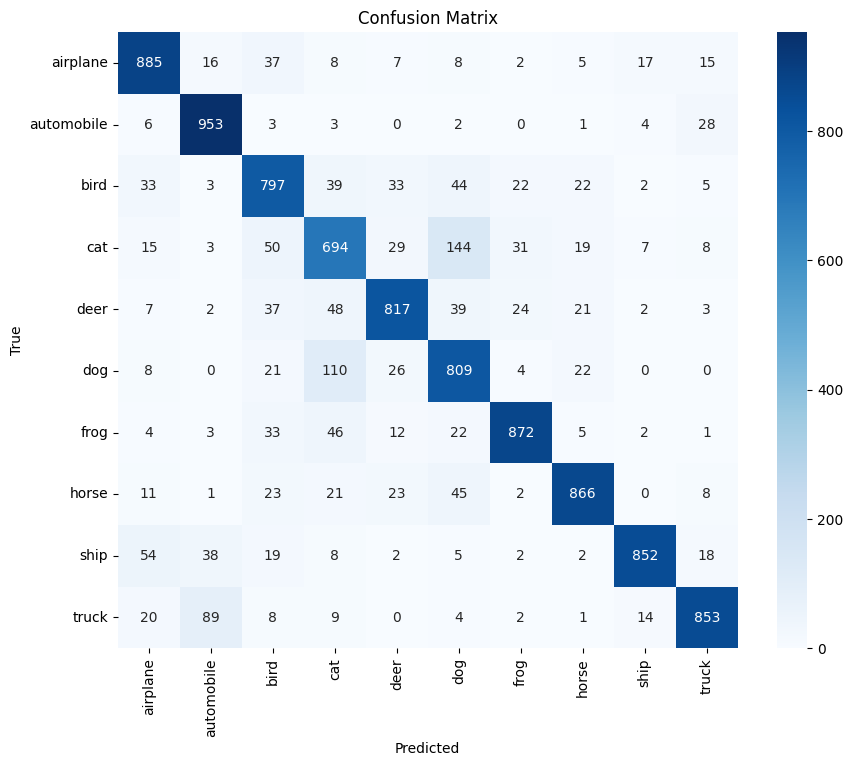

Accuracy: 0.8398
Recall: 0.8398
Learning rate: 0.0001
Epoch 1, Loss: 2.1315117332458495
Validation Accuracy: 28.65%
Epoch 2, Loss: 1.90926741771698
Validation Accuracy: 33.61%
Epoch 3, Loss: 1.8124095085144043
Validation Accuracy: 36.56%
Epoch 4, Loss: 1.7446925632476806
Validation Accuracy: 38.06%
Epoch 5, Loss: 1.6838729042053222
Validation Accuracy: 40.25%
Epoch 6, Loss: 1.6336242448806764
Validation Accuracy: 41.57%
Epoch 7, Loss: 1.5913591247558594
Validation Accuracy: 42.8%
Epoch 8, Loss: 1.56214165725708
Validation Accuracy: 43.97%
Epoch 9, Loss: 1.528004896736145
Validation Accuracy: 45.6%
Epoch 10, Loss: 1.5040243091583252
Validation Accuracy: 46.68%
Epoch 11, Loss: 1.475606311225891
Validation Accuracy: 47.32%
Epoch 12, Loss: 1.4562706359863282
Validation Accuracy: 47.82%
Epoch 13, Loss: 1.4322775808334351
Validation Accuracy: 48.79%
Epoch 14, Loss: 1.4153721509933472
Validation Accuracy: 49.54%
Epoch 15, Loss: 1.3948481824874879
Validation Accuracy: 49.67%
Epoch 16, Loss: 1.

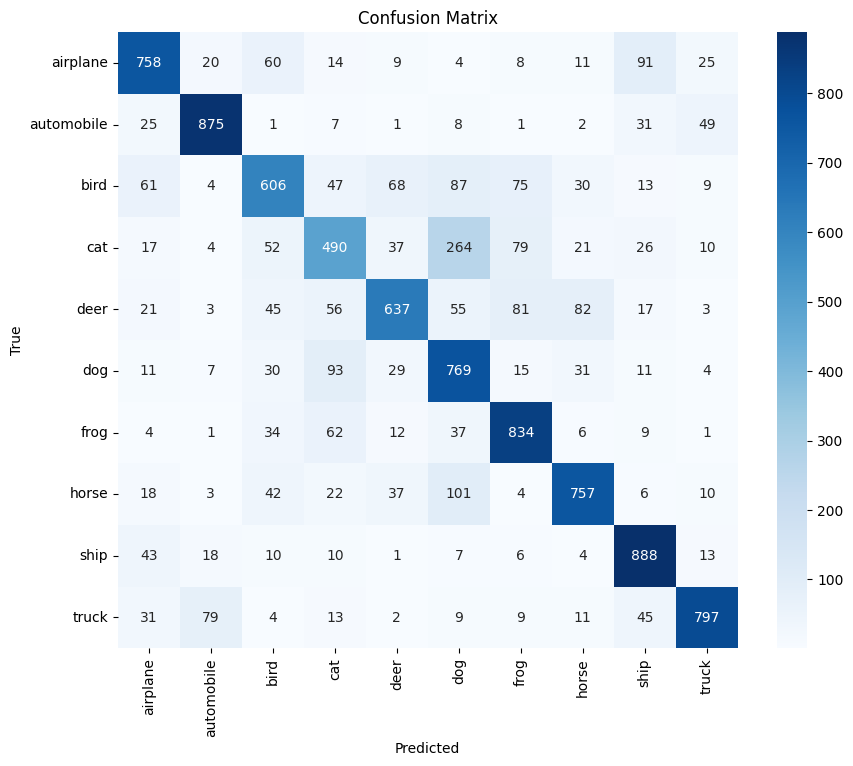

Accuracy: 0.7411
Recall: 0.7411


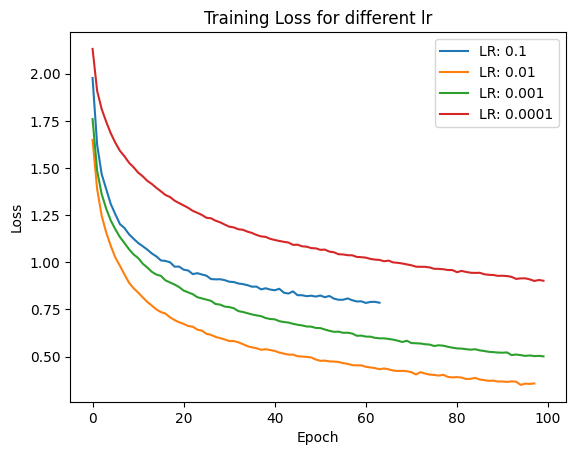

   Learning Rate  Test Accuracy
0         0.1000         0.7774
1         0.0100         0.8466
2         0.0010         0.8398
3         0.0001         0.7411
   Learning Rate  Test Recall
0         0.1000       0.7774
1         0.0100       0.8466
2         0.0010       0.8398
3         0.0001       0.7411


In [45]:
lrs = [1e-1, 1e-2, 1e-3, 1e-4]

import matplotlib.pyplot as plt

train_losses = []
test_accuracies = []
test_recalls = []


for lr in lrs:
    model = Net().to(device)
    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    print(f'Learning rate: {lr}')
    losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
    train_losses.append(losses)
    print()
    # 在训练完成后，调用测试函数
    test_accuracy, test_recall = test_draw_model(model, test_loader, device)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

for i, losses in enumerate(train_losses):
    plt.plot(losses, label=f'LR: {lrs[i]}')

plt.title('Training Loss for different lr')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Create a table to compare test accuracy for each learning rate
import pandas as pd

data = {'Learning Rate': lrs, 'Test Accuracy': test_accuracies}
df = pd.DataFrame(data)
print(df)

data = {'Learning Rate': lrs, 'Test Recall': test_recalls}
df = pd.DataFrame(data)
print(df)



Epoch 1, Loss: 2.2451033388137818
Validation Accuracy: 20.71%
Epoch 2, Loss: 1.9394031885147094
Validation Accuracy: 28.49%
Epoch 3, Loss: 1.750054942893982
Validation Accuracy: 35.22%
Epoch 4, Loss: 1.631765185546875
Validation Accuracy: 37.76%
Epoch 5, Loss: 1.5305319356918334
Validation Accuracy: 43.93%
Epoch 6, Loss: 1.4473896404266358
Validation Accuracy: 49.45%
Epoch 7, Loss: 1.371808315372467
Validation Accuracy: 51.19%
Epoch 8, Loss: 1.3153755851745605
Validation Accuracy: 50.72%
Epoch 9, Loss: 1.262498922252655
Validation Accuracy: 55.75%
Epoch 10, Loss: 1.215573840713501
Validation Accuracy: 57.16%
Epoch 11, Loss: 1.1676595733642579
Validation Accuracy: 57.98%
Epoch 12, Loss: 1.1227354351043701
Validation Accuracy: 60.07%
Epoch 13, Loss: 1.0838821906089782
Validation Accuracy: 60.15%
Epoch 14, Loss: 1.050723970222473
Validation Accuracy: 59.35%
Epoch 15, Loss: 1.0217850511550903
Validation Accuracy: 62.27%
Epoch 16, Loss: 0.9885209856987
Validation Accuracy: 64.31%
Epoch 17, 

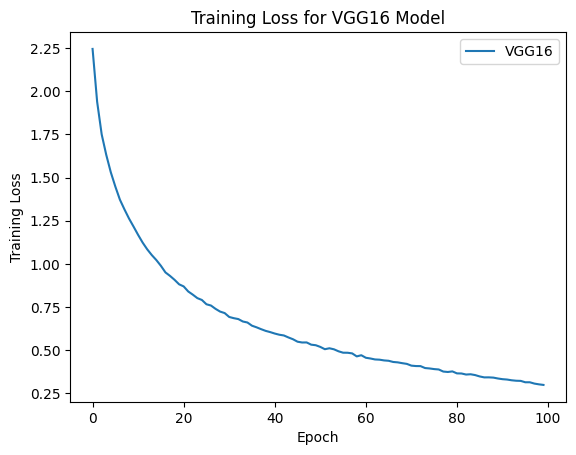

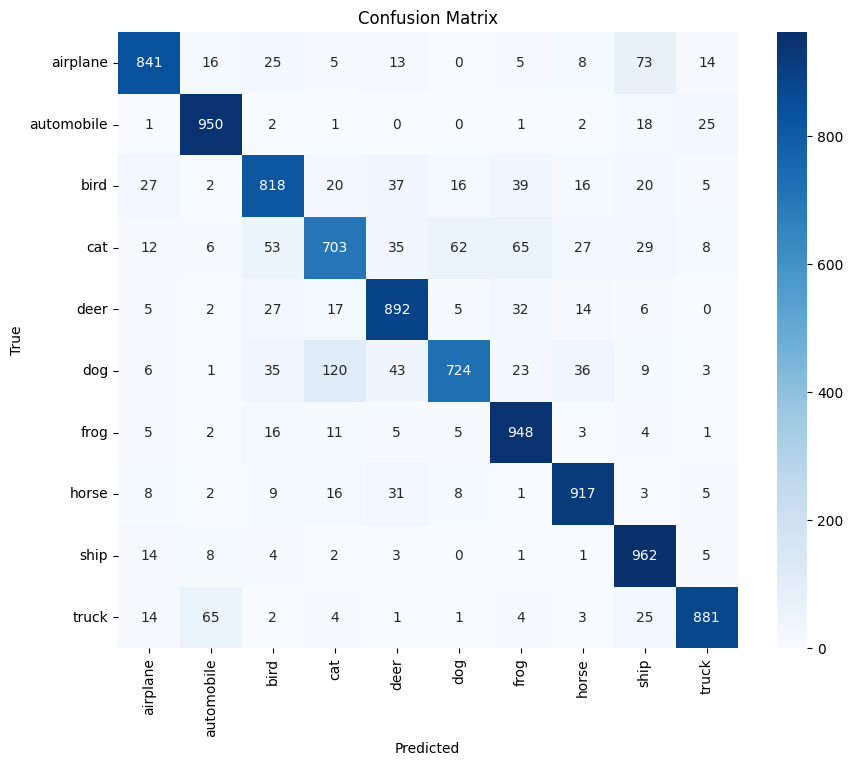

Accuracy: 0.8636
Recall: 0.8635999999999999


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16

train_losses = []
lr=1e-3

# Instantiate the VGG16 model
model = vgg16(num_classes=10).to(device)

# Define the loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Train the model
losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
train_losses.append(losses)

# Plot the training losses for each loss function
for i, losses in enumerate(train_losses):
    plt.plot(losses, label=f'VGG16')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for VGG16 Model')
plt.legend()
plt.show()

print()
# 在训练完成后，调用测试函数
test_accuracy, test_recall = test_draw_model(model, test_loader, device)



In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.shortcut(identity)
        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * BasicBlock.expansion
            stride = 1
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = F.avg_pool2d(out, 4)  # Global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [48]:
# 实例化模型
model = ResNet(BasicBlock, num_blocks=[2, 2, 2, 2], num_classes=10)

# 检查是否有可用的GPU，如果有则使用GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Epoch 1, Loss: 1.6875129388809205
Validation Accuracy: 44.37%
Epoch 2, Loss: 1.3319313548088074
Validation Accuracy: 52.98%
Epoch 3, Loss: 1.161703892993927
Validation Accuracy: 56.82%
Epoch 4, Loss: 1.0524351424217224
Validation Accuracy: 62.25%
Epoch 5, Loss: 0.9655105041503906
Validation Accuracy: 62.73%
Epoch 6, Loss: 0.8891414347648621
Validation Accuracy: 67.87%
Epoch 7, Loss: 0.8309157501220703
Validation Accuracy: 70.03%
Epoch 8, Loss: 0.7773196374893189
Validation Accuracy: 71.48%
Epoch 9, Loss: 0.734947878074646
Validation Accuracy: 71.24%
Epoch 10, Loss: 0.6961315033435822
Validation Accuracy: 71.45%
Epoch 11, Loss: 0.6653084884643554
Validation Accuracy: 72.87%
Epoch 12, Loss: 0.6398196632862091
Validation Accuracy: 75.37%
Epoch 13, Loss: 0.6177966630458832
Validation Accuracy: 76.37%
Epoch 14, Loss: 0.5868454421520233
Validation Accuracy: 76.38%
Epoch 15, Loss: 0.5683301087379455
Validation Accuracy: 78.14%
Epoch 16, Loss: 0.5540976191520691
Validation Accuracy: 78.19%
Epo

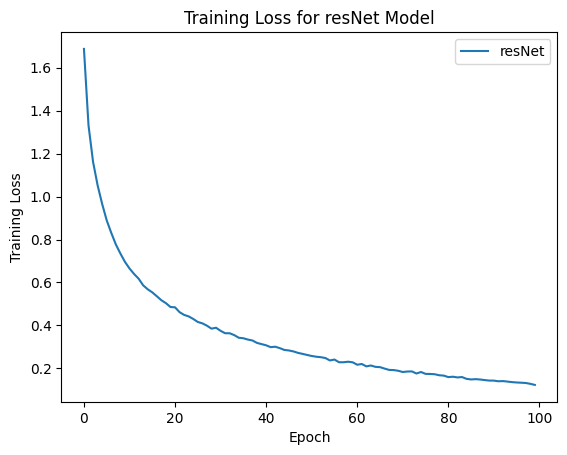

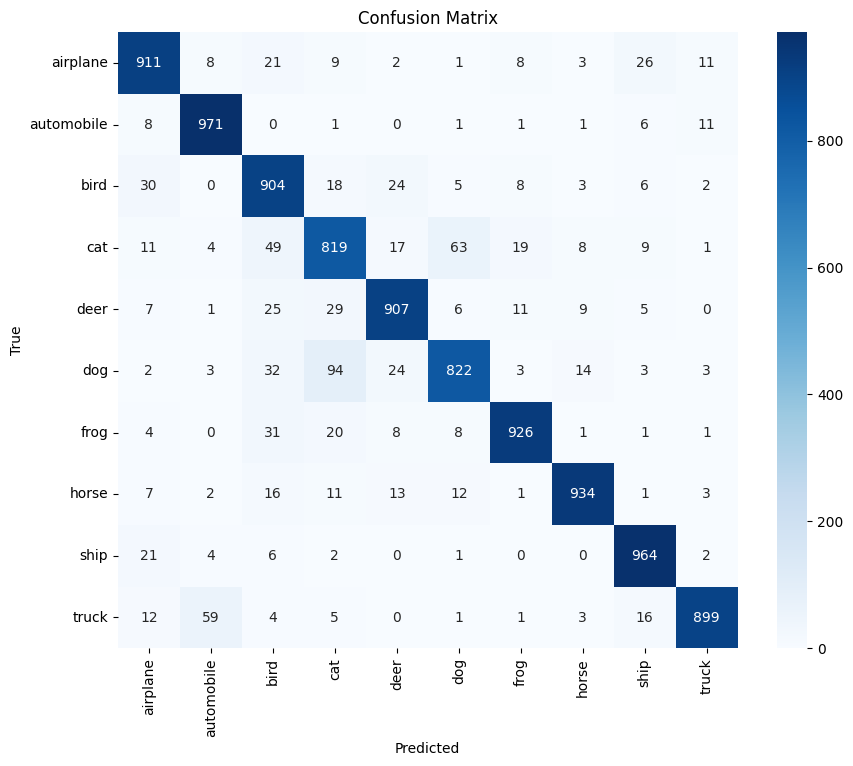

Accuracy: 0.9057
Recall: 0.9057000000000002


In [49]:
train_losses = []

# 定义损失函数和优化器
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

# Train the model
losses = train_model(model, train_loader, valid_loader, epochs, device, loss_func)
train_losses.append(losses)

# Plot the training losses for each loss function
for i, losses in enumerate(train_losses):
    plt.plot(losses, label=f'resNet')

plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss for resNet Model')
plt.legend()
plt.show()

print()
# 在训练完成后，调用测试函数
test_accuracy, test_recall = test_draw_model(model, test_loader, device)